In [1]:
import os
import time

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf

import basenji
from basenji import bed
from basenji import dataset
from basenji import seqnn
from basenji import trainer
from basenji import gene as bgene
from basenji import dna_io

import json

import pyranges as pr

import kipoiseq
from kipoiseq import Interval
import pyfaidx

import pysam

import matplotlib.pyplot as plt
import matplotlib.patches as patches


2023-08-08 16:40:42.677183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:40:47.901327: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-08 16:40:47.901484: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-08 16:40:47.901498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#Read model parameters

params_file = "params_pred.json"

with open(params_file) as params_open :
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets (GTEx RNA-seq)
targets_file = '../bench_apa/targets_gtex.txt'

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Model ensemble parameters
n_folds = 1
SEQUENCE_LENGTH = 524288


In [3]:
#Get exon annotation as dataframe
exons_gff_file = '/home/drk/seqnn/analysis/2022/10-19/gencode41_basic_nort_protein_exons.gff'

exons_pr = pr.read_gtf(exons_gff_file)

exons_pr = exons_pr[exons_pr.Feature == 'exonic_part']
exons_pr = exons_pr.drop('Source')
exons_pr = exons_pr.drop('Score')

print("len(exons_pr) = " + str(len(exons_pr)))

#Get basic gene annotation as dataframe
gene_gff_file = './gencode.v41.basic.annotation.gff3'

gene_pr = pr.read_gff3(gene_gff_file)

gene_pr = gene_pr[gene_pr.Feature.isin(['gene', 'exon', 'five_prime_UTR', 'three_prime_UTR'])]

gene_pr = gene_pr.drop('Source')
gene_pr = gene_pr.drop('Score')
gene_pr = gene_pr.drop('Frame')
gene_pr = gene_pr.drop('ID')
gene_pr = gene_pr.drop('hgnc_id')
gene_pr = gene_pr.drop('havana_gene')
gene_pr = gene_pr.drop('Parent')
gene_pr = gene_pr.drop('transcript_support_level')
gene_pr = gene_pr.drop('tag')
gene_pr = gene_pr.drop('havana_transcript')
gene_pr = gene_pr.drop('ont')
gene_pr = gene_pr.drop('protein_id')
gene_pr = gene_pr.drop('ccdsid')
gene_pr = gene_pr.drop('artif_dupl')
gene_pr = gene_pr.drop('level')

print("len(gene_pr) = " + str(len(gene_pr)))

#Get pA annotation as dataframe
polya_gff_file = './gencode.v41.polyAs.gff3'

polya_pr = pr.read_gff3(polya_gff_file)

polya_pr = polya_pr[polya_pr.Feature.isin(['polyA_signal', 'polyA_site'])]

polya_pr = polya_pr.drop('Source')
polya_pr = polya_pr.drop('Score')
polya_pr = polya_pr.drop('Frame')
polya_pr = polya_pr.drop('ID')
polya_pr = polya_pr.drop('gene_type')
polya_pr = polya_pr.drop('gene_name')
polya_pr = polya_pr.drop('transcript_type')
polya_pr = polya_pr.drop('transcript_name')
polya_pr = polya_pr.drop('level')

print("len(polya_pr) = " + str(len(polya_pr)))

#Concatenate annotations

gene_pr = pr.concat([gene_pr, polya_pr])

print("[Final] len(gene_pr) = " + str(len(gene_pr)))


len(exons_pr) = 291246
len(gene_pr) = 1077833
len(polya_pr) = 92482
[Final] len(gene_pr) = 1170315


In [4]:
#Helper functions / classes

from scipy.ndimage import gaussian_filter

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

import gc

#Function to get a one-hot coded sequence pattern
def make_seq_1hot(genome_open, chrm, start, end, seq_len):
    if start < 0:
        seq_dna = 'N'*(-start) + genome_open.fetch(chrm, 0, end)
    else:
        seq_dna = genome_open.fetch(chrm, start, end)
    
    #Extend to full length (pad)
    if len(seq_dna) < seq_len:
        seq_dna += 'N'*(seq_len-len(seq_dna))
    
    seq_1hot = dna_io.dna_1hot(seq_dna)
    
    return seq_1hot

#Function to inject into model definition to get attention scores
def _get_attention_weights(self, inputs, training=False) :
    
    #Initialise the projection layers
    embedding_size = self._value_size * self._num_heads
    seq_len = inputs.shape[1]

    #Compute q, k and v as multi-headed projections of the inputs
    q = self._multihead_output(self._q_layer, inputs)  # [B, H, T, K]
    k = self._multihead_output(self._k_layer, inputs)  # [B, H, T, K]
    v = self._multihead_output(self._v_layer, inputs)  # [B, H, T, V]

    #Scale the query by the square-root of key size
    if self._scaling :
        q *= self._key_size**-0.5

    #[B, H, T', T]
    content_logits = tf.matmul(q + self._r_w_bias, k, transpose_b=True)

    if self._num_position_features == 0 :
        logits = content_logits
    else :
        #Project positions to form relative keys.
        distances = tf.range(-seq_len + 1, seq_len, dtype=tf.float32)[tf.newaxis]
        positional_encodings = basenji.layers.positional_features(
              positions=distances,
              feature_size=self._num_position_features,
              seq_length=seq_len,
              symmetric=self._relative_position_symmetric)
        #[1, 2T-1, Cr]
      
        if training :
            positional_encodings = tf.nn.dropout(
                positional_encodings, rate=self._positional_dropout_rate)

        #[1, H, 2T-1, K]
        r_k = self._multihead_output(self._r_k_layer, positional_encodings)

        #Add shifted relative logits to content logits.
        if self._content_position_bias :
            #[B, H, T', 2T-1]
            relative_logits = tf.matmul(q + self._r_r_bias, r_k, transpose_b=True)
        else :
            #[1, H, 1, 2T-1]
            relative_logits = tf.matmul(self._r_r_bias, r_k, transpose_b=True)
            #[1, H, T', 2T-1]
            relative_logits = tf.broadcast_to(relative_logits, shape=(1, self._num_heads, seq_len, 2*seq_len-1))

        #[B, H, T', T]
        relative_logits = basenji.layers.relative_shift(relative_logits)
        logits = content_logits + relative_logits

    #Apply Softmax across length
    weights = tf.nn.softmax(logits)
    
    return weights

#Function to create a new Keras model, outputting a specific attention layer's scores
def get_attention_model(seqnn_model, layer_ix=0, inital_offset=30, offset=11) :

    #Create new model object
    attention_model = tf.keras.Model(
        seqnn_model.model.layers[1].inputs,
        _get_attention_weights(
            seqnn_model.model.layers[1].layers[inital_offset + offset * layer_ix],
            seqnn_model.model.layers[1].layers[inital_offset + offset * layer_ix - 1].output,
        ),
    )
    
    return attention_model

#Function to predict tracks and attention scores
def predict_tracks_and_attention_scores(models, sequence_one_hot, track_scale=1., track_transform=1., clip_soft=None, n_layers=8, score_rc=True) :
    
    n_folds = len(models)
    
    attention_scores = []
    predicted_tracks = []
    
    #Loop over folds
    for fold_ix in range(n_folds) :

        attention_scores_for_fold = []

        yh = models[fold_ix](sequence_one_hot[None, ...])[:, None, ...].astype('float32')
        
        #Undo scale
        yh /= track_scale

        #Undo soft_clip
        if clip_soft is not None :
            yh_unclipped = (yh - clip_soft)**2 + clip_soft
            unclip_mask_h = (yh > clip_soft)

            yh[unclip_mask_h] = yh_unclipped[unclip_mask_h]

        #Undo sqrt
        yh = yh**(1. / track_transform)

        #Aggregate over tracks (average)
        ##yh = np.mean(yh, axis=-1)

        predicted_tracks.append(yh)

        #Loop over layers
        for layer_ix in range(n_layers) :

            #Get attention score model and make predictions
            attention_model = get_attention_model(models[fold_ix], layer_ix=layer_ix)
            att_scores = attention_model.predict(x=[sequence_one_hot[None, ...]], batch_size=1)
            
            #Optionally reverse-complement
            if score_rc :
                att_scores_rc = attention_model.predict(x=[sequence_one_hot[None, ::-1, ::-1]], batch_size=1)
                att_scores = (att_scores + att_scores_rc[..., ::-1, ::-1]) / 2.

            attention_scores_for_fold.append(att_scores[:, None, None, ...])

            attention_model = None
            gc.collect()

        #Concatenate
        attention_scores_for_fold = np.concatenate(attention_scores_for_fold, axis=2)
        attention_scores.append(attention_scores_for_fold)

    #Concatenate
    predicted_tracks = np.concatenate(predicted_tracks, axis=1)
    attention_scores = np.concatenate(attention_scores, axis=1)

    print("predicted_tracks.shape = " + str(predicted_tracks.shape))
    print("attention_scores.shape = " + str(attention_scores.shape))
    
    return predicted_tracks, attention_scores

#Function to predict tracks
def predict_tracks(models, sequence_one_hot, track_scale=1., track_transform=1., clip_soft=None) :
    
    n_folds = len(models)
    
    predicted_tracks = []
    
    #Loop over folds
    for fold_ix in range(n_folds) :

        yh = models[fold_ix](sequence_one_hot[None, ...])[:, None, ...].astype('float32')
        
        #Undo scale
        yh /= track_scale

        #Undo soft_clip
        if clip_soft is not None :
            yh_unclipped = (yh - clip_soft)**2 + clip_soft
            unclip_mask_h = (yh > clip_soft)

            yh[unclip_mask_h] = yh_unclipped[unclip_mask_h]

        #Undo sqrt
        yh = yh**(1. / track_transform)

        predicted_tracks.append(yh)

    #Concatenate
    predicted_tracks = np.concatenate(predicted_tracks, axis=1)
    print("predicted_tracks.shape = " + str(predicted_tracks.shape))
    
    return predicted_tracks

#Helper function to get (padded) one-hot and annotated sub-dataframe
def process_sequence(chrom, start, end) :
    
    seq_len = end - start

    #Pad sequence to input window size
    start -= (SEQUENCE_LENGTH - seq_len) // 2
    end += (SEQUENCE_LENGTH - seq_len) // 2

    annotation_df = gene_pr.df.query("Chromosome == '" + chrom + "' and ((End >= " + str(int(start)) + " and End < " + str(int(end)) + ") or (Start >= " + str(int(start)) + " and Start < " + str(int(end)) + "))")

    #Get one-hot
    sequence_one_hot = make_seq_1hot(fasta_open, chrom, start, end, seq_len)
    
    return sequence_one_hot.astype('float32'), annotation_df


In [5]:
#Initialize fasta sequence extractor

fasta_file = 'hg38.fa'

#!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
#pyfaidx.Faidx(fasta_file)

fasta_open = pysam.Fastafile(fasta_file)


In [6]:
#Load sequences.bed test sets for each model fold

fold_dfs = []
for fold_ix in range(n_folds) :
    
    df_bed = pd.read_csv('/home/drk/seqnn/data/models/v2/f0c0/data0/sequences.bed', names=['chrom', 'start', 'end', 'train_or_test'], sep='\t')
    
    test_df = df_bed.query("train_or_test == 'test'").copy().reset_index(drop=True)
    
    #Greedily keep only non-overlapping coordinate ranges
    keep_index = []
    
    for row_i, [_, row] in enumerate(test_df.iterrows()) :
        test_df_chrom = test_df.iloc[keep_index].query("chrom == '" + row['chrom'] + "'")
        
        if len(test_df_chrom.query("(" + str(row['start']) + " >= start and " + str(row['start']) + " < end) or (" + str(row['end']) + " >= start and " + str(row['end']) + " < end)")) <= 0 :
            keep_index.append(row_i)
    
    fold_dfs.append(test_df.iloc[keep_index].copy().reset_index(drop=True))

print("len(fold_dfs[0]) = " + str(len(fold_dfs[0])))


len(fold_dfs[0]) = 1430


In [7]:
#Load h3k4me4 peaks for a few representative tissues

min_q = 0.05

peak_dfs = []

files = [
    'ENCFF266XUO_GSM669925_H3K4me3_Adipose.bed',
    'ENCFF416SIL_GSM621675_H3K4me3_Liver.bed',
    'ENCFF726NBW_GSM621694_H3K4me3_Muscle.bed',
]

#Load and merge peaks
for file in files :
    
    peak_df = pd.read_csv(file, names=['chrom', 'start', 'end', 'peak_name', 'peak_score', 'strand', 'signal_value', 'pval', 'qval', 'offset'], sep='\t')
    
    signal_vals = np.array(peak_df['signal_value'].values)
    
    #Get quantile and filter on signal value
    min_q_val = np.quantile(signal_vals, q=min_q)
    peak_df = peak_df.query("signal_value >= " + str(min_q_val)).copy().reset_index(drop=True)
    
    peak_dfs.append(peak_df)

print("len(peak_dfs[0]) = " + str(len(peak_dfs[0])))


len(peak_dfs[0]) = 35323


In [8]:
import gc
import tensorflow.keras.backend as K

fold_ix = 0
n_test = 256

negative_frac = 4

peak_atts = [[] for peak_i in range(len(peak_dfs))]
peak_atts_neg = [[] for peak_i in range(len(peak_dfs))]

splice_atts = []
splice_atts_neg = []

pa_atts = []
pa_atts_neg = []

#Loop over test sequences
for test_ix in range(n_test) :
    
    print(" --- test_ix = " + str(test_ix) + " ---")
    
    #Get test sequence coordinates
    test_row = fold_dfs[fold_ix].iloc[test_ix]
    chrom, start, end = test_row['chrom'], test_row['start'], test_row['end']
    
    start -= (524288 - 196608) // 2
    end += (524288 - 196608) // 2
    
    #Get test sequence
    sequence_one_hot, annotation_df = process_sequence(chrom, start, end)

    #Potentially re-initialize model ensemble (to deal with memory fragmentation issues)
    if test_ix % 8 == 0 :
        K.clear_session()

        models = []
        model_file = "../bench_apa/test_apa/f" + str(fold_ix) + "c0/train/model0_best.h5"

        seqnn_model = seqnn.SeqNN(params_model)
        seqnn_model.restore(model_file, 0, by_name=False)
        seqnn_model.build_slice(target_index)
        seqnn_model.build_ensemble(True, '0')

        models.append(seqnn_model)

    #Predict attention scores
    _, attention_scores = predict_tracks_and_attention_scores(models, sequence_one_hot, score_rc=True)

    fold_index = [0]
    layer_index = [5, 6]
    head_index = [0, 1, 2, 3, 4, 5, 6, 7]

    att = np.mean(
        np.mean(
            np.mean(
                attention_scores[:, fold_index, ...]
                , axis=1
            )[:, layer_index, ...]
            , axis=1
        )[:, head_index, ...]
        , axis=1
    )[0, ...]
    
    gc.collect()

    #Extract attention bin positions from regions overlapping H3K4me3 peaks
    peak_bins = []
    
    for peak_i in range(len(peak_dfs)) :
        
        peak_df = peak_dfs[peak_i].query("chrom == '" + chrom + "' and start + offset >= " + str(start) + " and start + offset < " + str(end))
        peak_bins.append([])

        #Loop over annotated peaks
        for _, peak_row in peak_df.iterrows() :
            att_bin_start = max(int(np.round((peak_row['start'] - start) / 128.)), 0)
            att_bin_end = min(int(np.round((peak_row['end'] - start) / 128.) + 1), 4096)

            if att_bin_end > att_bin_start :
                peak_bins[peak_i].append(np.arange(att_bin_start, att_bin_end, dtype='int32').tolist())

    #Extract attention bin positions from exons or regions overlapping pA sites
    splice_df = annotation_df.query("Feature == 'exon' and gene_type == 'protein_coding'").drop_duplicates(subset=['exon_id'], keep='first').drop_duplicates(subset=['Chromosome', 'Start', 'End'], keep='first').copy().reset_index(drop=True)[['Chromosome', 'Start', 'End']]
    pa_df = annotation_df.query("Feature == 'polyA_signal'").drop_duplicates(subset=['Chromosome', 'Start', 'End'], keep='first').copy().reset_index(drop=True)[['Chromosome', 'Start', 'End']]
    
    splice_bins = []
    
    #Loop over annotated splice junctions
    for _, splice_row in splice_df.iterrows() :
        att_bin_start = max(int(np.round((splice_row['Start'] - start) / 128.)), 0)
        att_bin_end = min(int(np.round((splice_row['End'] - start) / 128.) + 1), 4096)

        if att_bin_end > att_bin_start :
            splice_bins.append(np.arange(att_bin_start, att_bin_end, dtype='int32').tolist())
    
    pa_bins = []
    #Loop over annotated polyA sites
    for _, pa_row in pa_df.iterrows() :
        att_bin_start = max(int(np.round((pa_row['Start'] - start - 64) / 128.)), 0)
        att_bin_end = min(int(np.round((pa_row['End'] - start + 64) / 128.) + 1), 4096)

        if att_bin_end > att_bin_start :
            pa_bins.append(np.arange(att_bin_start, att_bin_end, dtype='int32').tolist())
    
    #Concatenate all non-background bins
    all_bins = splice_bins + pa_bins
    for peak_i in range(len(peak_bins)) :
        all_bins = all_bins + peak_bins[peak_i]
    
    if len(all_bins) > 0 :
        all_bin_set = set(np.concatenate([np.array(bin_set) for bin_set in all_bins], axis=0).tolist())

        #Construct negative bins
        negative_bins = [bin_ix for bin_ix in np.arange(4096).tolist() if bin_ix not in all_bin_set]

        #Construct matched negative sets and accumulate across test set (promoters)
        for peak_i in range(len(peak_bins)) :
            
            if len(peak_bins[peak_i]) > 0 :
                
                peak_bins_neg = []
                
                #Loop over bins and sample negatives
                for bin_set in peak_bins[peak_i] :
                    for negative_frac_ix in range(negative_frac) :
                        peak_bins_neg.append(np.random.choice(negative_bins, size=(len(bin_set),), replace=True).tolist())

                peak_att = np.array([np.mean(att[:, peak_bins[peak_i][bin_set_ix]]) for bin_set_ix in range(len(peak_bins[peak_i]))], dtype='float32')
                peak_att_neg = np.array([np.mean(att[:, peak_bins_neg[bin_set_ix]]) for bin_set_ix in range(len(peak_bins_neg))], dtype='float32')

                peak_atts[peak_i].append(peak_att)
                peak_atts_neg[peak_i].append(peak_att_neg)
        
        #Matched splice set
        if len(splice_bins) > 0 :
                
            splice_bins_neg = []

            #Loop over bins and sample negatives
            for bin_set in splice_bins :
                for negative_frac_ix in range(negative_frac) :
                    splice_bins_neg.append(np.random.choice(negative_bins, size=(len(bin_set),), replace=True).tolist())

            splice_att = np.array([np.mean(att[:, splice_bins[bin_set_ix]]) for bin_set_ix in range(len(splice_bins))], dtype='float32')
            splice_att_neg = np.array([np.mean(att[:, splice_bins_neg[bin_set_ix]]) for bin_set_ix in range(len(splice_bins_neg))], dtype='float32')

            splice_atts.append(splice_att)
            splice_atts_neg.append(splice_att_neg)
        
        #Matched pA set
        if len(pa_bins) > 0 :
                
            pa_bins_neg = []

            #Loop over bins and sample negatives
            for bin_set in pa_bins :
                for negative_frac_ix in range(negative_frac) :
                    pa_bins_neg.append(np.random.choice(negative_bins, size=(len(bin_set),), replace=True).tolist())

            pa_att = np.array([np.mean(att[:, pa_bins[bin_set_ix]]) for bin_set_ix in range(len(pa_bins))], dtype='float32')
            pa_att_neg = np.array([np.mean(att[:, pa_bins_neg[bin_set_ix]]) for bin_set_ix in range(len(pa_bins_neg))], dtype='float32')

            pa_atts.append(pa_att)
            pa_atts_neg.append(pa_att_neg)

#Loop over peak tissue types and concatenate scores
for peak_i in range(len(peak_bins)) :
    print("")
    print("peak_i = " + str(peak_i))
    
    peak_atts[peak_i] = np.concatenate(peak_atts[peak_i], axis=0)
    peak_atts_neg[peak_i] = np.concatenate(peak_atts_neg[peak_i], axis=0)

    print("peak_atts[peak_i].shape = " + str(peak_atts[peak_i].shape))
    print("peak_atts_neg[peak_i].shape = " + str(peak_atts_neg[peak_i].shape))

print("")
print("(splice)")

#Concatenate splice scores
splice_atts = np.concatenate(splice_atts, axis=0)
splice_atts_neg = np.concatenate(splice_atts_neg, axis=0)

print("splice_atts.shape = " + str(splice_atts.shape))
print("splice_atts_neg.shape = " + str(splice_atts_neg.shape))

print("")
print("(pA)")

#Concatenate polyA scores
pa_atts = np.concatenate(pa_atts, axis=0)
pa_atts_neg = np.concatenate(pa_atts_neg, axis=0)

print("pa_atts.shape = " + str(pa_atts.shape))
print("pa_atts_neg.shape = " + str(pa_atts_neg.shape))


 --- test_ix = 0 ---
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-08-08 16:43:08.505362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:43:09.063173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10398 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 524288, 4)]  0           []                               
                                                                                                  
 stochastic_reverse_complement   ((None, 524288, 4),  0          ['sequence[0][0]']               
 (StochasticReverseComplement)   ())                                                              
                                                                                                  
 stochastic_shift (StochasticSh  (None, 524288, 4)   0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                           
                                                                                            

2023-08-08 16:43:20.615340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-08-08 16:43:20.929661: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 1 ---
1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 2 ---
1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 3 ---
1/1 [==============================] - 0s 29ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 4 ---
1/1 [==============================] - 0s 30ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 5 ---
1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 6 ---
1/1 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 26ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 106 ---
1/1 [==============================] - 0s 28ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 107 ---
1/1 [==============================] - 0s 28ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 108 ---
1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 109 ---
1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 110 ---
1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 29ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 164 ---
1/1 [==============================] - 0s 29ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 165 ---
1/1 [==============================] - 0s 29ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 166 ---
1/1 [==============================] - 0s 31ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 167 ---
1/1 [==============================] - 0s 27ms/step
predicted_tracks.shape = (1, 1, 16352, 89)
attention_scores.shape = (1, 1, 8, 8, 4096, 4096)
 --- test_ix = 168 ---
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape

- H3K4me3 -
--- GSM669925_Adipose ---
 - n (pos) = 1570
 - n (neg) = 6280
 -- p = 0.0
 -- s = 52.9357


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


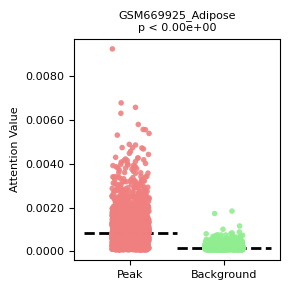

--- GSM621675_Liver ---
 - n (pos) = 1854
 - n (neg) = 7416
 -- p = 0.0
 -- s = 42.6267


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


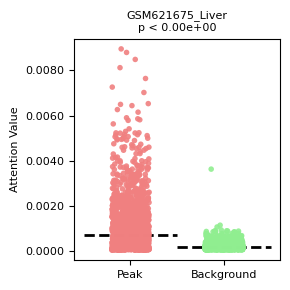

--- GSM621694_Muscle ---
 - n (pos) = 2206
 - n (neg) = 8824
 -- p = 0.0
 -- s = 54.3695


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


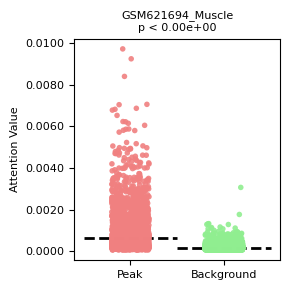

In [10]:
#Visualize enrichment of attention overlapping H3K4me3 peaks

import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import ranksums

save_figs = True

print("- H3K4me3 -")

peak_names = [
    'GSM669925_Adipose',
    'GSM621675_Liver',
    'GSM621694_Muscle',
]

#Loop over peak sets (tissues)
for peak_i in range(len(peak_bins)) :
    
    print("--- " + peak_names[peak_i] + " ---")
    
    peak_att = peak_atts[peak_i]
    peak_att_neg = peak_atts_neg[peak_i]
    
    #Compute two-sided ranksum test
    s_val, p_val = ranksums(peak_att, peak_att_neg, alternative='two-sided')
    
    print(" - n (pos) = " + str(peak_att.shape[0]))
    print(" - n (neg) = " + str(peak_att_neg.shape[0]))
    print(" -- p = " + str(p_val))
    print(" -- s = " + str(round(s_val, 4)))

    median_att = np.median(peak_att)
    median_att_neg = np.median(peak_att_neg)
    
    f = plt.figure(figsize=(3, 3))

    sns.stripplot(data=[peak_att, peak_att_neg], s=4, palette=['lightcoral', 'lightgreen'], alpha=0.9, jitter=0.2)
    
    plt.plot([-0.5, 0.5], [median_att, median_att], color='black', linestyle='--', linewidth=2)
    plt.plot([ 0.5, 1.5], [median_att_neg, median_att_neg], color='black', linestyle='--', linewidth=2)

    plt.title(peak_names[peak_i] + "\np < " + '{:.2e}'.format(p_val), fontsize=8)
    
    plt.xticks([0, 1], ["Peak", "Background"], fontsize=8)
    plt.yticks(fontsize=8)
    
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    plt.ylabel("Attention Value", fontsize=8)
    
    plt.tight_layout()
    
    if save_figs :
        plt.savefig("borzoi_v2_attention_h3k4me3_" + str(peak_names[peak_i]) + "_" + str(n_folds) + "_folds.png", transparent=False)
        plt.savefig("borzoi_v2_attention_h3k4me3_" + str(peak_names[peak_i]) + "_" + str(n_folds) + "_folds.eps")

    plt.show()


- Exons -
 - n (pos) = 13919
 - n (neg) = 55676
 -- p = 0.0
 -- s = 159.1133


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


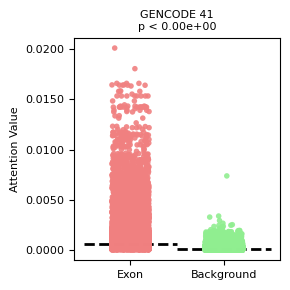

In [11]:
#Visualize enrichment of attention overlapping exons

import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import ranksums

save_figs = True

print("- Exons -")

#Compute two-sided ranksum test
s_val, p_val = ranksums(splice_atts, splice_atts_neg, alternative='two-sided')

print(" - n (pos) = " + str(splice_atts.shape[0]))
print(" - n (neg) = " + str(splice_atts_neg.shape[0]))
print(" -- p = " + str(p_val))
print(" -- s = " + str(round(s_val, 4)))

median_att = np.median(splice_atts)
median_att_neg = np.median(splice_atts_neg)

f = plt.figure(figsize=(3, 3))

sns.stripplot(data=[splice_atts, splice_atts_neg], s=4, palette=['lightcoral', 'lightgreen'], alpha=0.9, jitter=0.2)

plt.plot([-0.5, 0.5], [median_att, median_att], color='black', linestyle='--', linewidth=2)
plt.plot([ 0.5, 1.5], [median_att_neg, median_att_neg], color='black', linestyle='--', linewidth=2)

plt.title("GENCODE 41\np < " + '{:.2e}'.format(p_val), fontsize=8)

plt.xticks([0, 1], ["Exon", "Background"], fontsize=8)
plt.yticks(fontsize=8)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.ylabel("Attention Value", fontsize=8)

plt.tight_layout()

if save_figs :
    plt.savefig("borzoi_v2_attention_exons_" + str(n_folds) + "_folds.png", transparent=False)
    plt.savefig("borzoi_v2_attention_exons_" + str(n_folds) + "_folds.eps")

plt.show()


- pA sites -
 - n (pos) = 1919
 - n (neg) = 7676
 -- p = 0.0
 -- s = 54.1067


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


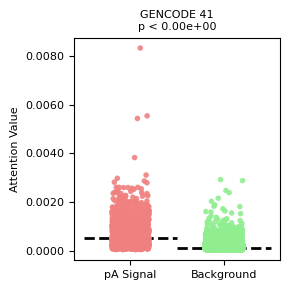

In [12]:
#Visualize enrichment of attention overlapping pA sites

import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import ranksums

save_figs = True

print("- pA sites -")

#Compute two-sided ranksum test
s_val, p_val = ranksums(pa_atts, pa_atts_neg, alternative='two-sided')

print(" - n (pos) = " + str(pa_atts.shape[0]))
print(" - n (neg) = " + str(pa_atts_neg.shape[0]))
print(" -- p = " + str(p_val))
print(" -- s = " + str(round(s_val, 4)))

median_att = np.median(pa_atts)
median_att_neg = np.median(pa_atts_neg)

f = plt.figure(figsize=(3, 3))

sns.stripplot(data=[pa_atts, pa_atts_neg], s=4, palette=['lightcoral', 'lightgreen'], alpha=0.9, jitter=0.2)

plt.plot([-0.5, 0.5], [median_att, median_att], color='black', linestyle='--', linewidth=2)
plt.plot([ 0.5, 1.5], [median_att_neg, median_att_neg], color='black', linestyle='--', linewidth=2)

plt.title("GENCODE 41\np < " + '{:.2e}'.format(p_val), fontsize=8)

plt.xticks([0, 1], ["pA Signal", "Background"], fontsize=8)
plt.yticks(fontsize=8)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.ylabel("Attention Value", fontsize=8)

plt.tight_layout()

if save_figs :
    plt.savefig("borzoi_v2_attention_pa_" + str(n_folds) + "_folds.png", transparent=False)
    plt.savefig("borzoi_v2_attention_pa_" + str(n_folds) + "_folds.eps")

plt.show()
